In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from numpy.ma import masked_array

from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid

from ekarus.e2e.single_stage_ao_class import SingleStageAO


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [ ]:
def define_target_roi(pupil, iwa, owa, oversampling:int, symmetric:bool=False, heightInLambdaOverD=None):
    mask_shape = max(pupil.shape)
    padded_pupil = xp.pad(1-pupil.copy(), pad_width=int((mask_shape*(oversampling-1)//2)), mode='constant', constant_values=0.0)
    X,Y = image_grid(padded_pupil.shape,recenter=True)
    rho = xp.sqrt(X**2+Y**2)
    if symmetric is True:
        where = (rho <= owa*oversampling) * (rho >= iwa*oversampling)
    else:
        where = (rho <= owa*oversampling) * (X >= iwa*oversampling) 
    if heightInLambdaOverD is not None:
        where *= (abs(Y) < heightInLambdaOverD/2*oversampling)
    return where

# def define_target_roi(pupil, iwa, owa, oversampling:int, symmetric:bool=False):
#     mask_shape = max(pupil.shape)
#     padded_pupil = xp.pad(1-pupil.copy(), pad_width=int((mask_shape*(oversampling-1)//2)), mode='constant', constant_values=0.0)
#     X,Y = image_grid(padded_pupil.shape,recenter=True)
#     rho = xp.sqrt(X**2+Y**2)
#     where = (rho <= owa*oversampling) * (rho >= iwa*oversampling)
#     if symmetric is not True:
#         where *= X>=0
#     return where


def define_apodizing_phase(pupil, res_phi_in_rad, roi, R, IF,
                           oversampling:int, max_its:int=200,
                           initial_guess=None, gains=0.1,
                           change_gain_its:list=None, #beta:float=0.0,
                           show_step:int=None):
    if change_gain_its is not None:
        assert len(change_gain_its) == len(gains)-1
        gain_ctr = 0
        gain = gains[gain_ctr]
        change_gain_it = change_gain_its[gain_ctr]
    else:
        gain = gains
        change_gain_it = None

    mask_shape = max(pupil.shape)
    pad_width = int((mask_shape*(oversampling-1)//2))
    padded_pupil = xp.pad(1-pupil, pad_width=pad_width, mode='constant', constant_values=0.0)

    phi = reshape_on_mask(res_phi_in_rad, (pupil).astype(bool))
    field = (1-pupil) * xp.exp(1j*phi,dtype=xp.complex64)
    pad_field = xp.pad(field, pad_width=pad_width, mode='constant', constant_values=0.0)
    focal_field = xp.fft.fftshift(xp.fft.fft2(pad_field))
    ref_psf = xp.abs(focal_field)**2

    dm_phase = initial_guess if initial_guess is not None else xp.zeros_like(res_phi_in_rad)
    roi_contrast = xp.zeros([3,max_its])
    best_contrast = 0
    best_phase = dm_phase.copy()

    for j in range(max_its):
        phi = reshape_on_mask(res_phi_in_rad+dm_phase, (pupil).astype(bool))
        field = (1-pupil) * xp.exp(1j*phi,dtype=xp.complex64)
        pad_field = xp.pad(field, pad_width=pad_width, mode='constant', constant_values=0.0)
        focal_field = xp.fft.fftshift(xp.fft.fft2(pad_field))
        ff_roi = focal_field * roi
        pup_field_roi = xp.fft.ifft2(xp.fft.ifftshift(ff_roi))
        phase = xp.angle(pup_field_roi)[padded_pupil>0.0]
        cmd = R @ phase
        rec_phi = IF @ cmd

        contrast = xp.log10(xp.abs(focal_field)**2/xp.max(ref_psf))
        roi_contrast[0,j] = xp.max(contrast[roi])
        roi_contrast[1,j] = xp.mean(contrast[roi]) 
        roi_contrast[2,j] = xp.min(contrast[roi])

        if change_gain_it == j and change_gain_it is not None:
            gain_ctr += 1
            gain = gains[gain_ctr]
            if gain_ctr < len(change_gain_its):
                change_gain_it = change_gain_its[gain_ctr]
            else:
                change_gain_it = None

        # if j >= 2:
        #     curr_grad = float(roi_contrast[1,j] - roi_contrast[1,j-1])
        #     prev_grad = float(roi_contrast[1,j-1] - roi_contrast[1,j-2])
        #     if (abs(curr_grad) < 0.7 * abs(prev_grad)):
        #         half_counter += 1
        #     else:
        #         half_counter = 0
        #     if half_counter >= 10:
        #         print(f'Consecutive {half_counter} iterations where |grad| dropped below half; halving gain at iteration {j:1.0f}')
        #         gain *= 0.5
        #         half_counter = 0

        if xp.mean(contrast[roi]) < best_contrast:
            best_contrast = xp.mean(contrast[roi]) 
            best_phase = dm_phase.copy()

        if show_step is not None:
            if j % show_step == 0:
                plt.figure(figsize=(20,4))        
                plt.subplot(1,4,1)
                plt.imshow(masked_array(xp.asnumpy(phi),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
                plt.colorbar()
                plt.title('Field + DM phase')
                plt.subplot(1,4,4)
                plt.imshow(masked_array(xp.asnumpy(reshape_on_mask(rec_phi,(pupil).astype(bool))),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
                plt.colorbar()
                plt.title('Reconstructed DM phase')
                plt.subplot(1,4,3)
                plt.imshow(masked_array(xp.asnumpy(contrast),mask=xp.asnumpy(1-roi)),
                        origin='lower',cmap='twilight',vmin=-12,vmax=0)
                cbar=plt.colorbar()
                cbar.ax.set_title('Contrast')
                plt.xlim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.ylim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.title(f'ROI average contrast: {xp.mean(contrast[roi]):1.1f}')
                plt.subplot(1,4,2)
                plt.imshow(xp.asnumpy(contrast),origin='lower',cmap='twilight',vmin=-12,vmax=0)
                cbar=plt.colorbar()
                cbar.ax.set_title('Contrast')
                plt.xlim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.ylim([mask_shape*oversampling//2-mask_shape//2,mask_shape*oversampling//2+mask_shape//2])
                plt.title(f'PSF\nIteration {j:1.0f}')
        dm_phase -= gain * rec_phi
        # dm_phase = beta * dm_phase - rec_phi * (1 + beta)

    return best_phase, roi_contrast

In [3]:
def calc_psf(ef, oversampling:int=8):
    pad_width = int((max(ef.shape)*(oversampling-1)//2))
    pad_ef = xp.pad(ef, pad_width=pad_width, mode='constant', constant_values=0.0)
    ff = xp.fft.fftshift(xp.fft.fft2(pad_ef))
    return xp.real(ff * xp.conj(ff))

def show_psf(psf, norm=None, oversampling:int=8, title:str='', ext=0.3, vmin=-10):
    pixelSize = 1/oversampling
    imageHalfSizeInPoints= psf.shape[0]/2
    roi= [int(imageHalfSizeInPoints*(1-ext)), int(imageHalfSizeInPoints*(1+ext))]
    psfZoom = psf[roi[0]: roi[1], roi[0]:roi[1]]
    sz = psfZoom.shape
    if norm is None:
        norm = xp.max(psf)
    plt.imshow(xp.asnumpy(xp.log10(psfZoom/norm)), extent=
               [-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
               -sz[1]/2*pixelSize, sz[1]/2*pixelSize],
               origin='lower',cmap='inferno',vmin=vmin,vmax=0)
    plt.xlabel(r'$\lambda/D$')
    plt.ylabel(r'$\lambda/D$')
    cbar= plt.colorbar()
    cbar.ax.set_title('Contrast')
    plt.title(title)

In [4]:
ssao = SingleStageAO('offaxis_8m')
atmo_phases,res_phases = ssao.load_telemetry_data(data_keys=['mag7_atmo_phases','mag7_residual_phases'])

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps


Text(0.5, 1.0, 'Residual phase in [rad]')

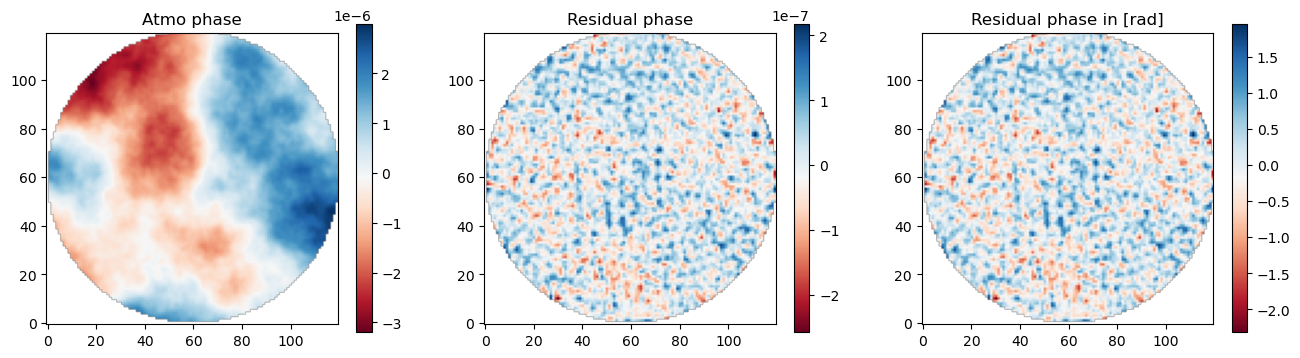

In [5]:
id = 100
m2rad = 2*xp.pi/ssao.pyr.lambdaInM
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(masked_array(atmo_phases[id].data,atmo_phases[id].mask),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Atmo phase')
plt.subplot(1,3,2)
plt.imshow(masked_array(res_phases[id].data,res_phases[id].mask),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Residual phase')
plt.subplot(1,3,3)
plt.imshow(masked_array(res_phases[id].data*m2rad,res_phases[id].mask),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Residual phase in [rad]')

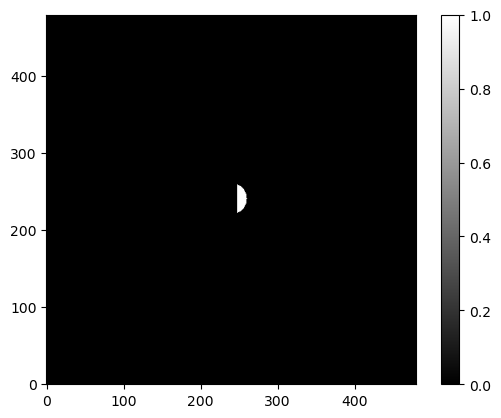

In [6]:
iwaInLambdaOverD = 2 #3.5
owaInLambdaOverD = 5 #7.5
heightInLambdaOverD = None
oversampling = 4
pupil = ssao.cmask.copy()

roi = define_target_roi(pupil, iwaInLambdaOverD, owaInLambdaOverD, oversampling, heightInLambdaOverD=heightInLambdaOverD)
plt.figure()
plt.imshow(xp.asnumpy(roi),origin='lower',cmap='gray')
plt.colorbar()

In [7]:
phi = xp.asarray(res_phases[id].data)*m2rad
res_phi_in_rad = phi[~pupil]

IF = ssao.dm.IFF.T
R = xp.linalg.pinv(IF)
dm_phi_in_rad, roi_contrast = define_apodizing_phase(pupil, 
                                  res_phi_in_rad, roi, IF, R, 
                                  oversampling=oversampling, max_its=1500, 
                                  gains=[0.02,0.001], change_gain_its = [100])#, show_step=30)

dh_phi_in_rad = dm_phi_in_rad + res_phi_in_rad

Text(0.5, 1.0, 'Contrast in dark zone')

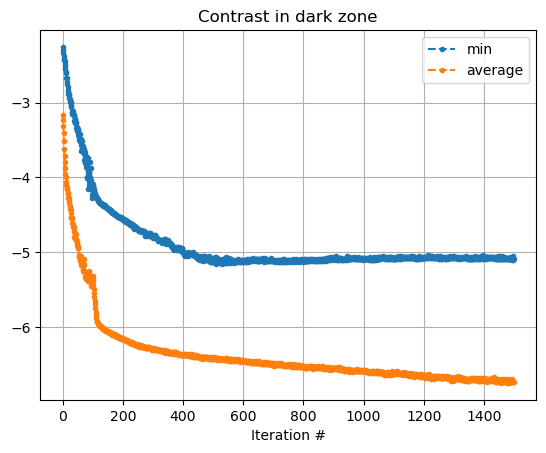

In [8]:
plt.figure()
plt.plot(xp.asnumpy(roi_contrast[0]),'--.',label='min')
plt.plot(xp.asnumpy(roi_contrast[1]),'--.',label='average')
# plt.plot(xp.asnumpy(roi_contrast[2]),'--.',label='max')
plt.legend()
plt.grid()
plt.xlabel('Iteration #')
plt.title('Contrast in dark zone')

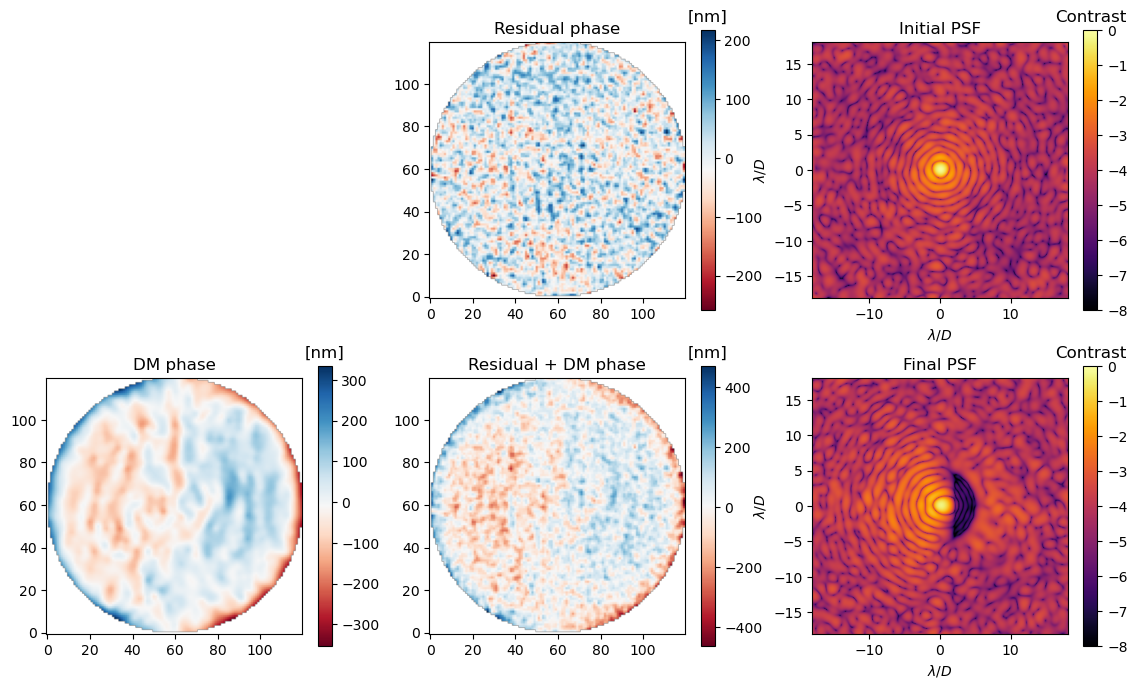

In [9]:
res_phi_2d = reshape_on_mask(res_phi_in_rad,pupil)
dm_phi_2d = reshape_on_mask(dm_phi_in_rad,pupil)

psf_oversampling = 12

dl_ef = (1-pupil) * xp.exp(1j*res_phi_2d*0,dtype=xp.complex64)
res_ef = (1-pupil) * xp.exp(1j*res_phi_2d,dtype=xp.complex64)
ef = (1-pupil) * xp.exp(1j*(res_phi_2d+dm_phi_2d),dtype=xp.complex64)

dl_psf = calc_psf(dl_ef, oversampling=psf_oversampling)
res_psf = calc_psf(res_ef, oversampling=psf_oversampling)
psf = calc_psf(ef, oversampling=psf_oversampling)

plt.figure(figsize=(14,8))
plt.subplot(2,3,2)
plt.imshow(masked_array(xp.asnumpy(res_phi_2d/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
cbar=plt.colorbar()
cbar.ax.set_title('[nm]')
plt.title('Residual phase')
plt.subplot(2,3,4)
plt.imshow(masked_array(xp.asnumpy(dm_phi_2d/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
cbar=plt.colorbar()
cbar.ax.set_title('[nm]')
plt.title('DM phase')
plt.subplot(2,3,5)
plt.imshow(masked_array(xp.asnumpy((dm_phi_2d+res_phi_2d)/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
cbar=plt.colorbar()
cbar.ax.set_title('[nm]')
plt.title('Residual + DM phase')
plt.subplot(2,3,6)
show_psf(psf, norm=xp.max(dl_psf), oversampling=psf_oversampling, title='Final PSF', vmin=-8)
plt.subplot(2,3,3)
show_psf(res_psf, norm=xp.max(dl_psf), oversampling=psf_oversampling, title='Initial PSF', vmin=-8)

/tmp/ipykernel_93401/2377962433.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Required number of FFTs')

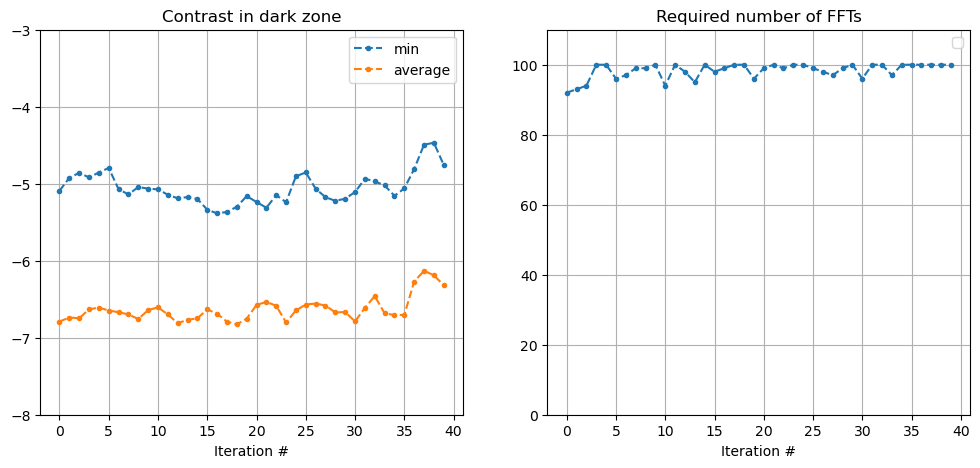

In [11]:
Nits = 40
step = 1
show_step = xp.inf #5
phi_guess = dm_phi_in_rad.copy()

req_its = xp.zeros(Nits)
contrasts = xp.zeros([2,Nits])

for i in range(Nits):
    phi = xp.asarray(res_phases[id+i*step].data)*m2rad
    res_phi_in_rad = phi[~pupil]

    dm_phi_i, roi_contrast = define_apodizing_phase(pupil, 
                                    res_phi_in_rad, roi, IF, R, 
                                    oversampling=oversampling, max_its=100, 
                                    gains=0.001, initial_guess=phi_guess)
    

    req_its[i] = xp.argmin(roi_contrast[1])
    contrasts[0,i] = roi_contrast[0,int(req_its[i])]
    contrasts[1,i] = roi_contrast[1,int(req_its[i])]

    phi_guess = dm_phi_i.copy()

    dm_cmd = R.T @ dm_phi_i/m2rad
    res_phi_2d = reshape_on_mask(res_phi_in_rad,pupil)
    dm_phi_2d = reshape_on_mask(dm_phi_i,pupil)
    ef = (1-pupil) * xp.exp(1j*(phi+dm_phi_2d),dtype=xp.complex64)
    psf = calc_psf(ef, oversampling=psf_oversampling)

    if i % show_step == 0 and i > 0:
        plt.figure(figsize=(20,3))
        plt.subplot(1,4,1)
        plt.imshow(masked_array(xp.asnumpy(res_phi_2d/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
        plt.axis('off')
        cbar=plt.colorbar()
        cbar.ax.set_title('[nm]')
        plt.title('Residual phase')
        plt.subplot(1,4,2)
        ssao.dm.plot_position(dm_cmd)    
        plt.axis('off')
        plt.title('DM command')
        plt.subplot(1,4,3)
        plt.imshow(masked_array(xp.asnumpy((dm_phi_2d+res_phi_2d)/m2rad*1e+9),mask=xp.asnumpy(pupil)),origin='lower',cmap='RdBu')
        cbar=plt.colorbar()
        cbar.ax.set_title('[nm]')
        plt.title('Residual + DM phase')
        plt.axis('off')
        plt.subplot(1,4,4)
        show_psf(psf, norm=xp.max(dl_psf), oversampling=psf_oversampling, title=f'PSF\n(DZ contrast: {xp.min(roi_contrast[1]):1.1f})', vmin=-8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(contrasts[0]),'--.',label='min')
plt.plot(xp.asnumpy(contrasts[1]),'--.',label='average')
plt.legend()
plt.grid()
plt.ylim([-8,-3])
plt.xlabel('Iteration #')
plt.title('Contrast in dark zone')
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(req_its)+1,'--.')
plt.ylim([0,110])
plt.legend()
plt.grid()
plt.xlabel('Iteration #')
plt.title('Required number of FFTs')
        